<a href="https://colab.research.google.com/github/shollercoaster/code-embedding-models/blob/main/Copy_of_Code_Commenter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improved Code Summarization
> "In this tutorial you'll learn about how to apply state of the art summarization models to source code!"

- toc: true
- badges: true
- comments: true
- categories: [code, summarization, deep-learning, seq2seq]
- image: images/code_commenting.png

# About
Hi there, in this post you'll learn how to finetune the a RoBERT based model that's been trained on code data to automatically generate comments for code!

We will be focusing on the Java programming language, but you can apply the same techniques in this post for any programming language that interests you. Additionally, you'll see how to incorporate this code commenter into a [VSCode](https://code.visualstudio.com/) extension so that you can generate comments for code snippets you highlight:

(Insert GIF of tool working)

As always, we'll start with a bit of background of the data and model we are using, but feel free to skip if you want to get straight to the awesomeness ;). Alright, let's GO!

# Background

## Data
We will be using the awesome [CodeSearchNet](https://github.com/github/codesearchnet) Challenge dataset, which contains millions of pairs of methods and their docstrings for a large variety of programming languages. The dataset was initially constructed for evaluating how well different approaches perform at searching for code. However, we can easily repurpose it for us and lucky for us, the awesome authors did an awesome job collecting, documenting, and cleaning the data.

We'll be performing a bit more cleaning and formatting of the data as well as adding some more examples. These examples won't be method/docstring pairs, but code snippet/inline comment pairs. This allows our model to generate comments for arbitrary code snippets that a developer may want to document instead of just generating the docstring of a method.

## CodeBERT
The pretrained model we will be finetuning comes from the awesome paper from Microsoft's research division aptly named [CodeBERT: A Pre-Trained Model for Programming and Natural Languages](https://arxiv.org/abs/2002.08155). This model also used the CodeSearchNet challenge dataset, but instead of using it to generate comments it used to teach a RoBERTa based model to represent code and natural language in a useful way. This practice of eaching these large language models to represent text in a useful way is common practice now since these representations have been shown to be helpful in finetuning these models on other tasks. The CodeBERT paper showed these representations are helpful by finetuning them on the programming task of code search and comment generation, exactly what we will be doing! The difference between their comment generation task and ours is that we will do a bit more preprocessing and our model will be able to generate inline comments of code snippets and not just method level comments.

So, how does CodeBERT learn these representations? It combines two different training objectives that's been shown to be useful for natural language. The Masked Language Modeling objective (MLM), which is from the original [BERT](https://arxiv.org/abs/1810.04805) paper, and Replaced Token Detection (RTD) objective, which is from the [ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators](https://arxiv.org/abs/2003.10555) paper. The MLM objective is where we randomly mask out parts of the text that we feed into the model and ask the model to predict those masked out pieces. The RTD objective is where random tokens in the text are replaced and the model has to determine which of these tokens are replaced. However, to make it harder for the model, these replaced tokens attempt to be plausible alternatives and not just random words. The CodeBERT model actually used a n-gram based model to generate these alternatives where as the ELECTRA paper used a small BERT based model.

![ELECTRA Pretraining Objective](https://nathancooper.io/i-am-a-nerd/images/electra.png) (From ELECTRA Paper)

Instead of using only natural language to apply these training objectives to, CodeBERT used code and docstrings. This allowed the CodeBERT model to learn a useful representation of code that could be used for other tasks.

Alright with that quick background knowledge down, lets get into actually finetuning our model!


In [ ]:
! nvidia-smi

Thu Oct  3 09:09:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Data

First we'll install the necessary packages and download our data!

In [17]:
# collapse
# Download and install the necessary dependencies
! pip install -q torch -f https://download.pytorch.org/whl/cu101/torch_stable.html
! pip install -q transformers==3.5.0 fast-trees

!pip install -q datasets

! git clone -q https://github.com/microsoft/CodeXGLUE.git

# Download the CodeSearchNet Challenge dataset for the Java programming language
!wget https://zenodo.org/record/7857872/files/java.zip
!unzip java.zip


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'CodeXGLUE' already exists and is not an empty directory.
--2024-10-03 10:31:13--  https://zenodo.org/record/7857872/files/java.zip
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY


Next let's read in our data and since these models take a long time to train, we will only select a subset of the data.

In [18]:
from datasets import load_dataset

data_files = {
"train": ['java/final/jsonl/train/java_train_0.jsonl.gz',
'java/final/jsonl/train/java_train_1.jsonl.gz'
]
}
raw_dataset = load_dataset("json", data_files=data_files)
print(raw_dataset.keys())
print(raw_dataset["train"][0].keys())
raw_dataset["train"][0]['func_name']

Generating train split: 0 examples [00:00, ? examples/s]

dict_keys(['train'])
dict_keys(['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition'])


'IndexedElementsBinder.bindIndexed'

In [19]:
raw_dataset["train"][0]['partition']

'train'

In [20]:
from datasets import Dataset

# Convert the dataset to a pandas DataFrame for easy manipulation
df = pd.DataFrame(raw_dataset['train'])

# Rename the 'code' and 'docstring' columns
df = df[['code', 'docstring']].rename(columns={'code': 'method', 'docstring': 'comment'})

# Split the dataset into train, validation, and test sets
train_df = df.sample(frac=0.8, random_state=42)  # 80% for training
test_val_df = df.drop(train_df.index)

# Split the remaining 20% into validation and test sets (50% each of the remaining data)
val_df = test_val_df.sample(frac=0.5, random_state=42)  # 10% for validation
test_df = test_val_df.drop(val_df.index)  # 10% for testing

# Convert back to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [9]:
# collapse
import pandas as pd

from pathlib import Path
from typing import List, Optional

# Code from CodeSearchNetChallenge: https://github.com/github/CodeSearchNet/blob/master/notebooks/ExploreData.ipynb
def jsonl_list_to_dataframe(file_list, columns=['code', 'docstring']):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f,
                                   orient='records',
                                   compression='gzip',
                                   lines=True)[columns]
                      for f in file_list], sort=False)

def get_dfs(path: Path) -> List[pd.DataFrame]:
    """Grabs the different data splits and converts them into dataframes"""
    dfs = []
    for split in ["train", "valid", "test"]:
        files = sorted((path/split).glob("**/*.gz"))
        df = jsonl_list_to_dataframe(split).rename(columns = {'code': 'method', 'docstring': 'comment'})
        dfs.append(df)

    return dfs

path = Path('.')
# ds = load_dataset("code_search_net", "java")

train_df, val_df, test_df = get_dfs(str(raw_dataset)) # path/"java/final/jsonl")
sample = 0.01
train_df = train_df.sample(frac = sample)
val_df = val_df.sample(frac = sample)
test_df = test_df.sample(frac = sample)



len(train_df), len(val_df), len(test_df)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

Let's see how the data looks. As shown, we have the data in a good format with one column all of the methods (input into the model) and the other all of the comments (output of the model).

In [21]:
train_df.head()

,method,comment
12628,@com.netflix.servo.annotations.Monitor(name = ...,Gets the threshold for the renewals per minute...
37730,"public <K, V> StatefulRedisConnection<K, V> co...",Open a new connection to a Redis server. Use t...
39991,public static ExecutionResult failure(Throwabl...,Returns a an ExecutionResult with the {@code f...
8525,"public static int lineEnd(ByteBuffer buffer, i...",一行的末尾位置，查找位置时位移ByteBuffer到结束位置<br>\n支持的换行符如下：\...
8279,"public static DateBetween create(Date begin, D...",创建<br>\n在前的日期做为起始时间，在后的做为结束时间，间隔只保留绝对值正数\n\n@p...


## Data Cleaning

Now, that we have the data, let's clean it! First, we'll remove any non-ascii characters to simplify the problem so that the model only has to think about generating English comments.

In [22]:
# collapse
# From https://stackoverflow.com/a/27084708/5768407
def is_ascii(s):
    '''
    Determines if the given string contains only ascii characters

    :param s: the string to check
    :returns: whether or not the given string contains only ascii characters
    '''
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

train_df = train_df[train_df['method'].apply(lambda x: is_ascii(x))]
val_df = val_df[val_df['method'].apply(lambda x: is_ascii(x))]
test_df = test_df[test_df['method'].apply(lambda x: is_ascii(x))]

train_df = train_df[train_df['comment'].apply(lambda x: is_ascii(x))]
val_df = val_df[val_df['comment'].apply(lambda x: is_ascii(x))]
test_df = test_df[test_df['comment'].apply(lambda x: is_ascii(x))]

len(train_df), len(val_df), len(test_df)

(42744, 5341, 5325)

Next, we'll remove any outdated comments by checking to see if the [JavaDoc](https://www.oracle.com/java/technologies/javase/javadoc.html)'s parameter list is different from the method's parameter list. This also will remove pairs where the docstring doesn't actually document the parameters, which probably means the pairs are poor quality (you should always properly document your code :) ).

In [30]:
!pip install -q fast_trees
!pip install -q tree-sitter==0.2.0


In [31]:
# collapse
import re

from fast_trees.core import FastParser

parser = FastParser('java')

def get_comment_params(comment: str) -> List[str]:
    '''
    Grabs the parameter identifier names from a JavaDoc comment

    :param comment: the comment to extract the parameter identifier names from
    :returns: an array of the parameter identifier names found in the given comment
    '''
    params = re.findall('@param+\s+\w+', comment)
    param_names = []
    for param in params:
        param_names.append(param.split()[1])

    return param_names

def is_outdated(method: str, comment: str, parser: FastParser) -> bool:
    '''
    Determines if a given method and comment are outdated by checking
    if the method's parameter identifier names match the comment's

    :param method: the method to compare against its corresponding comment
    :param comment: the comment to compare against its corresponding method
    :param parser: parser for easily getting the parameter identifier names from a given method
    :returns: wheather or not a given comment is outdated compared to its corresponding method
    '''
    try:
        method_params = parser.get_params(method)
    except:
        return False

    comment_params = get_comment_params(comment)

    return method_params != comment_params

train_df = train_df[
    ~train_df.apply(
        lambda x: is_outdated(x.method, x.comment, parser), axis = 1
    )
]
val_df = val_df[
    ~val_df.apply(
        lambda x: is_outdated(x.method, x.comment, parser), axis = 1
    )
]
test_df = test_df[
    ~test_df.apply(
        lambda x: is_outdated(x.method, x.comment, parser), axis = 1
    )
]

len(train_df), len(val_df), len(test_df)

Repo already exists, continuing.


ValueError: Incompatible Language version 14. Must not be between 9 and 12

Now we'll add in the additional pairs of code snippets/inline comments.

P.S. One thing to note with adding these pairs is that the inline comments will appear twice in the datasets. The first in the method where the inline comment came from and the second in the target for the code snippet. This is only a problem for the training set since it allows for the model to cheat by simply remembering the inline comment from the example method it came from. However, in my testing, I found this to not be an issue and the model seems to still work well despite this problem. Just thought ya should know :).

In [33]:
# collapse
from tqdm.auto import tqdm

def get_inline_pairs(method):
    '''
    Get all pairs of inline comments and corresponding code snippets

    :param method: the method to retrieve the pairs of comments and corresponding
    code snippets from
    :returns: all pairs of comments and corresponding code snippets
    '''
    pairs = [[]]

    comment = False
    bracket = False
    indent_lvl = -1
    lines = method.split("\n")
    for line in lines:
        if "//" in line and not bracket and not "://" in line:
            pairs[-1].append(line)
            if '\t' in line:
                indent_lvl = line.count('\t')
            else:
                indent_lvl = line.split("//")[0].count(' ')
            comment = True
            bracket = False
        elif comment:
            if '{' in line and not bracket:
                bracket = True
                pairs[-1].append(line)
            elif '}' in line:
                line_indent = -1
                if '\t' in line:
                    line_indent = line.count('\t')
                else:
                    line_indent = line.split("//")[0].count(' ')
                if indent_lvl == line_indent:
                    pairs[-1].append(line)
                if not bracket:
                    pairs.append([])
                    comment = False
                    bracket = False
            elif line.isspace() or line == '' and not bracket:
                pairs.append([])
                comment = False
            else:
                pairs[-1].append(line)

    # Convert pairs into proper format of (code snippet, inline comment) dataframe
    code_snippets   = []
    comments        = []
    for pair in pairs:
        if pair and len(pair) < 5:
            code    = []
            comment = []
            skip = False
            for line in pair:
                if "TODO" in line: break
                if "//" in line:
                    comment.append(line.replace('//', ''))
                else:
                    code.append(line)
            if len(code) > 1 and len(comment) > 0:
                        code_snippets.append('\n'.join(code))
                        comments.append('\n'.join(comment))

    pairs = pd.DataFrame(zip(code_snippets, comments), columns = ["method", "comment"])
    return pairs


def add_inline(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Helper function to go through all methods in a given dataframe and add all
    pairs of inline comments and corresponding code snippets

    :param df: the dataframe to retrieve and add all pairs of inline comments
    and corresponding code snippets to
    :returns: a new dataframe with the newly added pairs of inline comments and
    corresponding code snippets
    '''
    new_df = df[df['method'].str.contains("//")]
    all_pairs = []
    for method in tqdm(new_df.method.values):
        pairs = get_inline_pairs(method)
        all_pairs.append(pairs)

    df_pairs = pd.concat([pairs for pairs in all_pairs])
    return pd.concat([df, df_pairs])

train_df = add_inline(train_df)
val_df = add_inline(val_df)
test_df = add_inline(test_df)

len(train_df), len(val_df), len(test_df)

  0%|          | 0/8080 [00:00<?, ?it/s]

  0%|          | 0/1054 [00:00<?, ?it/s]

  0%|          | 0/1031 [00:00<?, ?it/s]

(45660, 5709, 5725)

We'll also remove pairs where the size of the code is smaller than the comment. This is because I found that in these cases the comments contain a bunch of extra information that the model won't have access to such as how the method is being used by other methods in the software system.

In [34]:
# collapse
train_df = train_df[train_df.apply(lambda row: len(row.method) > len(row.comment), axis = 1)]
val_df = val_df[val_df.apply(lambda row: len(row.method) > len(row.comment), axis = 1)]
test_df = test_df[test_df.apply(lambda row: len(row.method) > len(row.comment), axis = 1)]

len(train_df), len(val_df), len(test_df)

(36001, 4469, 4511)

Next, we'll remove any examples that have the special \<code> tag since these also tend to contain extra information that the model doesn't have a good hope of generating.

In [35]:
# collapse
def has_code(comment: str) -> bool:
    '''
    Determinine if the given comment contains the HTML <code> tag

    :param comment: the comment to check whether it contains the HTML <code> tag
    :returns: whether or not the given comment contains the HTML <code> tag
    '''
    if '<code>' in comment: return True
    else: return False

train_df = train_df[~train_df['comment'].apply(lambda x: has_code(x))]
val_df = val_df[~val_df['comment'].apply(lambda x: has_code(x))]
test_df = test_df[~test_df['comment'].apply(lambda x: has_code(x))]

len(train_df), len(val_df), len(test_df)

(35209, 4367, 4408)

Lastly, we're gonna remove the JavaDoc parts of the comments other than the description since that is really all we care about. The other pieces of information can usually be autogenerated or may require external knowledge to document them.

In [36]:
# collapse
def remove_jdocs(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Remove the JavaDocs leaving only the description of the comment

    :param df: the pandas dataframe to remove the JavaDocs from
    :returns: a new pandas dataframe with the JavaDocs removed
    '''
    methods = []
    comments = []
    for i, row in tqdm(list(df.iterrows())):
        comment = row["comment"]
        # Remove {} text in comments from https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python/14598135
        comment = re.sub("([\{\[]).*?([\)\}])", '', comment)


        cleaned = []
        for line in comment.split('\n'):
            if "@" in line: break
            cleaned.append(line)
        comments.append('\n'.join(cleaned))
        methods.append(row["method"])
    new_df = pd.DataFrame(zip(methods, comments), columns = ["method", "comment"])

    return new_df

train_df = remove_jdocs(train_df);
val_df = remove_jdocs(val_df);
test_df = remove_jdocs(test_df);

  0%|          | 0/35209 [00:00<?, ?it/s]

  0%|          | 0/4367 [00:00<?, ?it/s]

  0%|          | 0/4408 [00:00<?, ?it/s]

Almost there! In this step, we'll remove any HTML tags from the comments so the model doesn't have to also learn HTML. Bless those that do...

In [37]:
# collapse
def clean_html(comment: str) -> str:
    '''
    Remove any HTML tags from a given comment

    :param comment: the comment to remove any HTML tags from
    :returns: the comment with any HTML tags removed
    '''
    result = re.sub(r"<.?span[^>]*>|<.?code[^>]*>|<.?p[^>]*>|<.?hr[^>]*>|<.?h[1-3][^>]*>|<.?a[^>]*>|<.?b[^>]*>|<.?blockquote[^>]*>|<.?del[^>]*>|<.?dd[^>]*>|<.?dl[^>]*>|<.?dt[^>]*>|<.?em[^>]*>|<.?i[^>]*>|<.?img[^>]*>|<.?kbd[^>]*>|<.?li[^>]*>|<.?ol[^>]*>|<.?pre[^>]*>|<.?s[^>]*>|<.?sup[^>]*>|<.?sub[^>]*>|<.?strong[^>]*>|<.?strike[^>]*>|<.?ul[^>]*>|<.?br[^>]*>", "", comment)
    return result

train_df.comment = train_df.comment.apply(clean_html)
val_df.comment = val_df.comment.apply(clean_html)
test_df.comment = test_df.comment.apply(clean_html)

FINALLY!! We'll make everything lower case, remove extra whitespace, remove empty comments, and remove duplicates.

In [38]:
# collapse
train_df = train_df.applymap(lambda x: ' '.join(x.split()).lower())
val_df = val_df.applymap(lambda x: ' '.join(x.split()).lower())
test_df = test_df.applymap(lambda x: ' '.join(x.split()).lower())

train_df = train_df[~(train_df['comment'] == '')]
val_df = val_df[~(val_df['comment'] == '')]
test_df = test_df[~(test_df['comment'] == '')]

train_df = train_df[~train_df['comment'].duplicated()]
val_df = val_df[~val_df['comment'].duplicated()]
test_df = test_df[~test_df['comment'].duplicated()]

len(train_df), len(val_df), len(test_df)

<ipython-input-38-86e66d759f5c>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train_df = train_df.applymap(lambda x: ' '.join(x.split()).lower())
<ipython-input-38-86e66d759f5c>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_df = val_df.applymap(lambda x: ' '.join(x.split()).lower())
<ipython-input-38-86e66d759f5c>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test_df = test_df.applymap(lambda x: ' '.join(x.split()).lower())


(25484, 3468, 3478)

Now let's see what the data looks like.

In [39]:
train_df.head()

,method,comment
0,@com.netflix.servo.annotations.monitor(name = ...,gets the threshold for the renewals per minute.
1,public static executionresult failure(throwabl...,"returns a an executionresult with the set, tru..."
2,private boolean readrequiredbytes() { int tota...,attempts to read the required bytes into nextf...
3,public static protocolnegotiator serverplainte...,create a server plaintext handler for grpc.
4,public final long getbeulong40() { if (positio...,return next 40-bit unsigned int from buffer. (...


## Data Exploring

As good Data Scientists, we will also explore our data to uncover any secrets. Data can be sneaky like that :).

In [40]:
# collapse
import numpy as np

from collections import Counter
from statistics import mean, median, stdev
from transformers import AutoTokenizer

def get_counter(df: pd.DataFrame, tokenizer: AutoTokenizer, col: str) -> Counter:
    '''
    Get the counts for each token in a given pandas dataframe column

    :param df: the pandas dataframe to get the counts of tokens from
    :param tokenizer: the tokenizer to use for tokenizing the rows in the pandas
    dataframe
    :param col: the column to grab rows from when tokenizing
    :returns: the counts of each token in the given pandas dataframe
    column
    '''
    toks = []
    for i, row in df.iterrows():
        toks.extend(tokenizer.tokenize(row[col]))

    cnt = Counter()
    for tok in toks:
        cnt[tok] += 1
    return cnt

tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
method_cnt = get_counter(train_df, tokenizer, 'method')
comment_cnt = get_counter(train_df, tokenizer, 'comment')
method_lens = train_df.method.apply(lambda x: len(tokenizer.tokenize(x))).values
comment_lens = train_df.comment.apply(lambda x: len(tokenizer.tokenize(x))).values
max_method_len = int(np.quantile(method_lens, 0.95))
max_comment_len = int(np.quantile(comment_lens, 0.95))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1227 > 512). Running this sequence through the model will result in indexing errors


In [41]:
# collapse
import matplotlib.pyplot as plt

def plot_counts(counts:Counter, top_k: Optional[int] = 30):
    '''
    Plot a bar chart of the most common tokens

    :param counts: the counts of each token
    :param top_k: the number of tokens to display in the plot
    '''
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

Let's look at the most common tokens in our methods and comments.

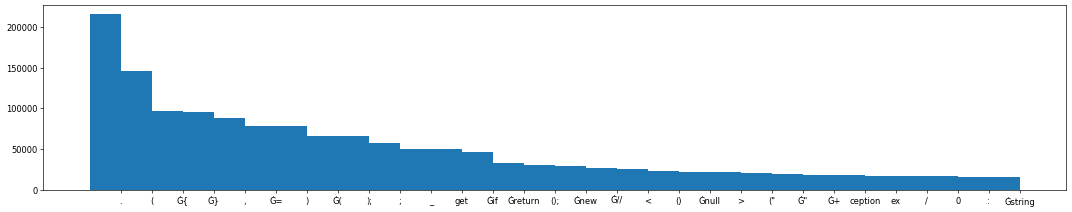

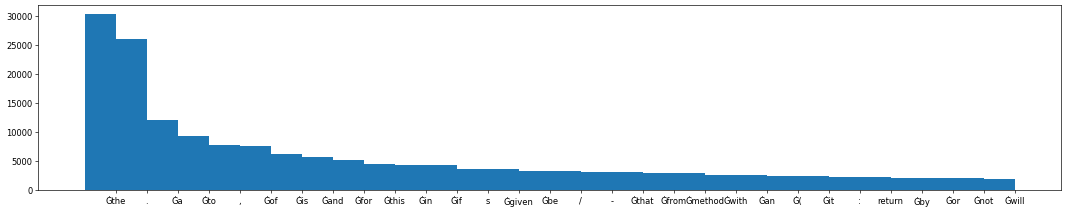

In [42]:
plot_counts(method_cnt, top_k = 30)
plot_counts(comment_cnt, top_k = 30)

In [43]:
# collapse
def plot_hist(lens: List[int], n_bins: Optional[int] = 50):
    '''
    Plot a histogram of the given number of tokens in a column

    :param lens: the number of tokens in a column
    :param n_bins: the number of bins to sort the number of tokens into
    '''
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Now, let's look at the distribution of method and comment lengths.

179 104.0 452.10950001078277


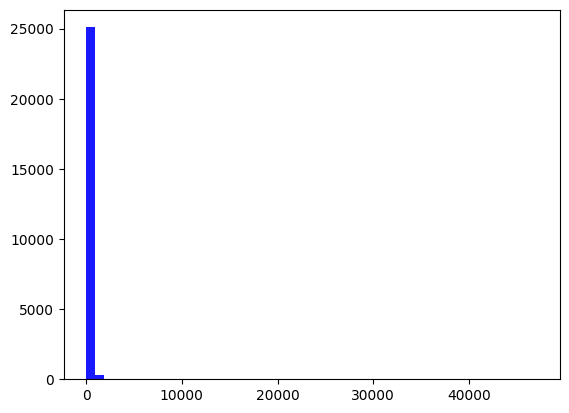

19 13.0 20.445048300260872


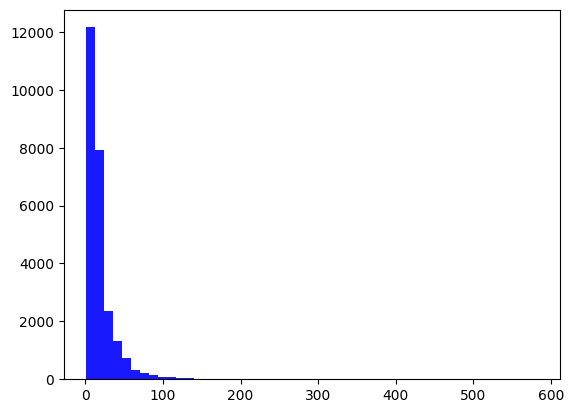

In [44]:
print(mean(method_lens), median(method_lens), stdev(method_lens))
plot_hist(method_lens)
print(mean(comment_lens), median(comment_lens), stdev(comment_lens))
plot_hist(comment_lens)

Using this new information on the length distribution, we can remove outliers by filter by lengths of methods that fall outside of 95th percentile (chosen for completely arbitrary reasons)!

In [45]:
# collapse
def filter_len(
    row: pd.Series, tokenizer: AutoTokenizer, method_len: int, comment_len: int
    ) -> bool:
    '''
    Determine if a given panda dataframe row has a method or comment that has
    more tokens than max length

    :param row: the row to check if it has a method or comment that is too long
    :param tokenizer: the tokenizer to tokenize a method or comment
    :param method_len: the max number of tokens a method can have
    :param comment_len: the max number of tokens a comment can have
    :returns: whether or not the given row have a method or comment that have
    more tokens than a max length
    '''
    return len(tokenizer.tokenize(row.method)) < method_len and len(tokenizer.tokenize(row.comment)) < comment_len

train_df = train_df[train_df.apply(
    lambda row: filter_len(
        row, tokenizer, max_method_len,
        max_comment_len
    ), axis = 1
)]
val_df = val_df[val_df.apply(
    lambda row: filter_len(
        row, tokenizer, max_method_len,
        max_comment_len
    ), axis = 1
)]
test_df = test_df[test_df.apply(
    lambda row: filter_len(
        row, tokenizer, max_method_len,
        max_comment_len
    ), axis = 1
)]

len(train_df), len(val_df), len(test_df)

(23169, 3144, 3130)

In [46]:
max_method_len, max_comment_len

(523, 54)

We could do a lot more exploring of our data as the above exploration was the bare minimum. As an exercise, I suggest for you to explore the data on your own using whatever means necessary!

# Training

Now that we have our data processed and in a format we like, let's go ahead and start training! To accomplish this we will be using code from the awesome [CodeXGLUE](https://github.com/microsoft/CodeXGLUE) repository. This repository is similar to the NLP equivalent GLUE benchmarks where a ton of awesome code related benchmarks are standardized and put into one place for the community to use! They have a ton of interesting ones and I highly suggest looking through their repo if you are interested in other code related tasks.

In [47]:
cd ./CodeXGLUE/Code-Text/code-to-text/code

/content/CodeXGLUE/Code-Text/code-to-text/code


In [48]:
# hide
! mkdir java

Okay, I lied, sorry :(. One last processing step is required of our data, which is to just output the data into the structure that the awesome CodeXGLUE Code-Text benchmark expects.

In [49]:
# collapse
import json

train_df['code_tokens'] = train_df.method.apply(lambda x: x.split())
train_df['docstring_tokens'] = train_df.comment.apply(lambda x: x.split())
with open('java/train.jsonl','w') as f:
    for _, row in train_df.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

val_df['code_tokens'] = val_df.method.apply(lambda x: x.split())
val_df['docstring_tokens'] = val_df.comment.apply(lambda x: x.split())
with open('java/valid.jsonl','w') as f:
    for _, row in val_df.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

test_df['code_tokens'] = test_df.method.apply(lambda x: x.split())
test_df['docstring_tokens'] = test_df.comment.apply(lambda x: x.split())
with open('java/test.jsonl','w') as f:
    for _, row in test_df.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

In [50]:
lang = 'java' # programming language
lr = 5e-5
batch_size = 8 # change depending on the GPU Colab gives you
beam_size = 10
source_length = 256
target_length = max_comment_len
data_dir = '.'
output_dir = f'model/{lang}'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
epochs = 10
pretrained_model = 'microsoft/codebert-base'

! python run.py \
    --do_train \
    --do_eval \
    --do_lower_case \
    --model_type roberta \
    --model_name_or_path {pretrained_model} \
    --train_filename {train_file} \
    --dev_filename {dev_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --train_batch_size {batch_size} \
    --eval_batch_size {batch_size} \
    --learning_rate {lr} \
    --num_train_epochs {epochs}

10/03/2024 11:39:49 - INFO - __main__ -   Namespace(model_type='roberta', model_name_or_path='microsoft/codebert-base', output_dir='model/java', load_model_path=None, train_filename='./java/train.jsonl', dev_filename='./java/valid.jsonl', test_filename=None, config_name='', tokenizer_name='', max_source_length=256, max_target_length=54, do_train=True, do_eval=True, do_test=False, do_lower_case=True, no_cuda=False, train_batch_size=8, eval_batch_size=8, gradient_accumulation_steps=1, learning_rate=5e-05, beam_size=10, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=10, max_steps=-1, eval_steps=-1, train_steps=-1, warmup_steps=0, local_rank=-1, seed=42)
10/03/2024 11:39:49 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior wil

Yay! Our model has finished baking and we can now see how well it turned out by evaluating it!

In [51]:
batch_size=64
dev_file=f"{data_dir}/{lang}/valid.jsonl"
test_file=f"{data_dir}/{lang}/test.jsonl"
test_model=f"{output_dir}/checkpoint-best-bleu/pytorch_model.bin" #checkpoint for test

! python run.py \
    --do_test \
    --model_type roberta \
    --model_name_or_path microsoft/codebert-base \
    --load_model_path {test_model} \
    --dev_filename {dev_file} \
    --test_filename {test_file} \
    --output_dir {output_dir} \
    --max_source_length {source_length} \
    --max_target_length {target_length} \
    --beam_size {beam_size} \
    --eval_batch_size {batch_size}

10/03/2024 12:39:55 - INFO - __main__ -   Namespace(model_type='roberta', model_name_or_path='microsoft/codebert-base', output_dir='model/java', load_model_path='model/java/checkpoint-best-bleu/pytorch_model.bin', train_filename=None, dev_filename='./java/valid.jsonl', test_filename='./java/test.jsonl', config_name='', tokenizer_name='', max_source_length=256, max_target_length=54, do_train=False, do_eval=False, do_test=True, do_lower_case=False, no_cuda=False, train_batch_size=8, eval_batch_size=64, gradient_accumulation_steps=1, learning_rate=5e-05, beam_size=10, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3, max_steps=-1, eval_steps=-1, train_steps=-1, warmup_steps=0, local_rank=-1, seed=42)
10/03/2024 12:39:55 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It wil

Let's now load up our model and take it for a spin!

In [52]:
# collapse
import torch

import torch.nn as nn

from model import Seq2Seq
from transformers import RobertaConfig, RobertaModel

config = RobertaConfig.from_pretrained(pretrained_model)
encoder = RobertaModel.from_pretrained(pretrained_model, config = config)
decoder_layer = nn.TransformerDecoderLayer(d_model=config.hidden_size, nhead=config.num_attention_heads)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
model = Seq2Seq(encoder = encoder,decoder = decoder,config=config,
                beam_size=beam_size,max_length=target_length,
                sos_id=tokenizer.cls_token_id,eos_id=tokenizer.sep_token_id)
model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))
model.to('cuda')

<ipython-input-52-9ed394e61e2f>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(Path(output_dir)/"checkpoint-last/pytorch_model.bin"))


Seq2Seq(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [53]:
idx = 0
TEXT_TO_SUMMARIZE = val_df.method.values[idx]
print('Code:', TEXT_TO_SUMMARIZE)
print('Original Comment:', val_df.comment.values[idx])

Code: public touchactions flick(int xspeed, int yspeed) { if (touchscreen != null) { action.addaction(new flickaction(touchscreen, xspeed, yspeed)); } return this; }
Original Comment: sends a flick gesture to the current view.


In [54]:
# collapse
from run import convert_examples_to_features, Example

class Args:
    max_source_length = source_length
    max_target_length = target_length

args = Args()

def get_preds(df: pd.DataFrame):
    ps = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.method, target = row.comment)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor(eval_features[0].source_ids, dtype = torch.long).unsqueeze(0).to('cuda')
        source_mask = torch.tensor(eval_features[0].source_mask, dtype = torch.long).unsqueeze(0).to('cuda')

        with torch.no_grad():
            preds = model(source_ids = source_ids, source_mask = source_mask)
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)

    return ps

In [55]:
val_df = val_df.reset_index()
preds = get_preds(val_df.head(10))
for idx, row in val_df.head(10).iterrows():
    print('Code:', row.method)
    print('Original Comment:', row.comment)
    print('Generated Comment:', preds[idx])
    print('='*40)

  0%|          | 0/10 [00:00<?, ?it/s]

/content/CodeXGLUE/Code-Text/code-to-text/code/model.py:77: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  zero=torch.cuda.LongTensor(1).fill_(0)


Code: public touchactions flick(int xspeed, int yspeed) { if (touchscreen != null) { action.addaction(new flickaction(touchscreen, xspeed, yspeed)); } return this; }
Original Comment: sends a flick gesture to the current view.
Generated Comment: todo:
Code: private static void setupcontextclassloader(groovyshell shell) { final thread current = thread.currentthread(); class dosetcontext implements privilegedaction { classloader classloader; public dosetcontext(classloader loader) { classloader = loader; } public object run() { current.setcontextclassloader(classloader); return null; } } accesscontroller.doprivileged(new dosetcontext(shell.getclassloader())); }
Original Comment: groovy-6771
Generated Comment: creates a classloader for the given context.
Code: public void decompose() { final double tiny = 1.0e-40; int mm = m1 + m2 + 1; index = new int[n]; au = new double[n][mm]; al = new double[n][m1]; for (int i = 0; i < a.length; i++) { system.arraycopy(a[i], 0, au[i], 0, a[i].length); 

The model seems to be doing a good job, but if you play with it some more you'll realize it is mostly taking the name of the method and using that to guide the comment. This makes sense, but it probably isn't learning much more than this association, at least with this small model. Let's explore it a bit more by looking at all the examples in the validation set it is failing the most on.

In [ ]:
def get_preds_losses(df: pd.DataFrame):
    ps = []
    losses = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        examples = [
            Example(idx, source = row.method, target = row.comment)
        ]
        eval_features = convert_examples_to_features(
            examples, tokenizer, args, stage='test'
        )
        source_ids = torch.tensor([f.source_ids for f in eval_features], dtype = torch.long).to('cuda')
        source_mask = torch.tensor([f.source_mask for f in eval_features], dtype = torch.long).to('cuda')
        target_ids = torch.tensor([f.target_ids for f in eval_features], dtype = torch.long).to('cuda')
        target_mask = torch.tensor([f.target_mask for f in eval_features], dtype = torch.long).to('cuda')

        with torch.no_grad():
            _, loss, _ = model(
                source_ids = source_ids, source_mask = source_mask,
                target_ids = target_ids, target_mask = target_mask
            )
            preds = model(source_ids = source_ids, source_mask = source_mask)
            for pred in preds:
                t = pred[0].cpu().numpy()
                t = list(t)
                if 0 in t:
                    t = t[:t.index(0)]
                text = tokenizer.decode(t,clean_up_tokenization_spaces=False)
                ps.append(text)
                losses.append(loss.item())

    return ps, losses

In [ ]:
df_head = val_df.copy()
ps, losses = get_preds_losses(df_head)
df_head['pred'] = ps
df_head['loss'] = losses
df_sorted_losses = df_head.sort_values('loss', ascending = False)

for _, row in df_sorted_losses.head(10).iterrows():
    print('Code:', row.method)
    print('Original Comment:', row.comment)
    print('Generated Comment:', row.pred)
    print(row.loss)
    print('='*40)


Code: private collection<artifact> getserverdependencies(final string servertype, final expressionevaluator expressionevaluator) throws componentconfigurationexception { try { final mavenproject project = (mavenproject) expressionevaluator.evaluate("${project}"); final string localrepo = (string) expressionevaluator.evaluate("${settings.localrepository}"); final artifactrepository localrepository = repositorysystem.createlocalrepository(new file(localrepo)); final repositoryrequest repositoryrequest = new defaultrepositoryrequest(); repositoryrequest.setremoterepositories(project.getremoteartifactrepositories()); repositoryrequest.setlocalrepository(localrepository); final artifactresolutionrequest request = new artifactresolutionrequest(repositoryrequest); request.setartifact(getserverartifact(servertype)); request.setresolvetransitively(true); final artifactresolutionresult result = repositorysystem.resolve(request); if (result.issuccess()) { return result.getartifacts(); } boolean 

# What's Next?

If you'd like to see how you can integrate this code comment summarizer model into the popular VSCode IDE, check out my video that goes over just that!

> youtube: https://youtu.be/SYjgPjQ-vbc